# Reproducibility as a Service Data Analysis
This notebook analyzes the data collected by executing R scripts with and without the retroactive reproducibility tool RaaS.
All plots, tables, and most numbers referenced in the paper are generated here.

Imports
---------

In [1]:
import os
import sqlite3
import json
import requests
import re
import matplotlib

import matplotlib.pyplot as plt
import pandas as pd
#import plotly.graph_objects as go
import seaborn as sns
import numpy as np

from glob import glob

from helper_functions import *

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 25}
matplotlib.rc('font', **font)

Analyzing scripts that ran __*without*__ RaaS
=======================================

These scripts executed in a rocker/tidyverse environment, R version 3.6.3, with a time limit of one script per hour, up to five hours per dataset.

We'll use three dataframes for this analysis, one at the granularity of scripts (`scripts_df`), one at the granularity of datasets (`dataset_df`), and a joined version (`overall_df`). 
Our first we'll process the raw data and generate these dataframes.

__Generate Scripts Dataframe__

In [2]:
con = sqlite3.connect("../data/results.db")

scripts_df = pd.read_sql_query("SELECT * FROM results", con) 
scripts_df["doi"] = get_doi_from_results_filename_v(scripts_df["filename"])
scripts_df["error_category"] = determine_error_cause_v(scripts_df["error"])

scripts_df = scripts_df[["filename", "error", "doi", "error_category"]]
scripts_df["unique_id"] = create_script_id_v(scripts_df["doi"].values, scripts_df["filename"].values)
scripts_df.columns = ['filename', 'nr_error', 'doi', 'nr_error_category', 'unique_id']

__Generate Datasets Dataframe__

In [3]:
# Load in metadata about each doi generated from get_doi_metadata.ipynb 
with open("../data/doi_metadata.json", "r") as doi_file:
    doi_metadata = json.loads(doi_file.read())

# Identify all subjects that R scripts were uploaded under on Dataverse
subject_set = set()
for doi_key in doi_metadata:
    if doi_metadata[doi_key][0] is not None:
        for subject in doi_metadata[doi_key][0]:
            subject_set.add(subject)   

In [4]:
# generate a dataset dataframe. Initialize and populate as a dict that we will later convert to a dataframe
df_dict = {"doi": [], "year":[]}
for subject in subject_set:
    df_dict[subject] = []

for doi_key in doi_metadata:
    if doi_metadata[doi_key][0] is not None:
        df_dict["year"].append(doi_metadata[doi_key][1])
        df_dict["doi"].append(doi_key.strip("\n"))
        for subject in subject_set:
            if subject in doi_metadata[doi_key][0]:
                df_dict[subject].append(True)
            else:
                df_dict[subject].append(False)

dataset_df = pd.DataFrame(df_dict)

In [5]:
# Add the time it took for each dataset to execute to the dataframe
no_raas_times = pd.read_csv("../data/dataset_times.csv")
dataset_df["nr_time"] = None
col_idx = dataset_df.columns.get_loc("nr_time")
for index, row in no_raas_times.iterrows():
    doi = get_doi_from_dir_path(row["doi"])
    row_idx = dataset_df[dataset_df["doi"] == doi].index
    dataset_df.iloc[row_idx, col_idx] = row["time"]
    
dataset_df = dataset_df[~dataset_df.nr_time.isna()]

In [6]:
# Add a boolean column identifying whether or not a dataset was 'clean,' aka no scripts had errors
clean_col = []
for doi in dataset_df["doi"].values:
    clean_col.append(is_clean(doi, scripts_df))
dataset_df["nr_clean"] = clean_col
dataset_df["nr_timed_out"] = False
no_raas_timeouts_dois = []
with open("../data/no_raas_timeouts.txt", "r") as no_raas_timeouts_file:
    no_raas_timeouts_dois = strip_newlines_v(no_raas_timeouts_file.readlines())

nr_timeout_idxs = dataset_df[dataset_df["nr_time"] > 18000].index
dataset_df.loc[nr_timeout_idxs, "nr_timed_out"] = True
valid_datasets_df = dataset_df[dataset_df["nr_timed_out"] == False]

__Generate Overall Joined Dataframe__

In [7]:
overall_df = scripts_df.join(dataset_df.set_index("doi"), on="doi")

Comparison of Chen's 2018 Study to our 2022 Study
------------------------------------------------

__Comparison of Total Errors and Successes__

In [8]:
total_num_scripts = len(scripts_df[scripts_df["nr_error"] != "timed out"].index)
num_success_scripts = len(scripts_df[scripts_df["nr_error_category"] == "success"].index)
num_error_scripts = len(scripts_df[~scripts_df.nr_error_category.isin(["success", "timed out"])].index)

In [9]:
chen_comparison_markdown = '''
------------------------------------------------
              Chen's              Ours 
  --------- -------- --------- ------- ---------
  Result       Count   Percent   Count   Percent

  Success        408     14.4%   OUR_SUCCESS_COUNT     OUR_SUCCESS_PERCENT%

  Error         2431     85.6%   OUR_ERROR_COUNT    OUR_ERROR_PERCENT%

  Total         2839             OUR_TOTAL 
------------------------------------------------
'''

chen_comparison_markdown = chen_comparison_markdown.replace("OUR_SUCCESS_COUNT", str(num_success_scripts))
chen_comparison_markdown = chen_comparison_markdown.replace("OUR_SUCCESS_PERCENT", "{0:.1f}".format(num_success_scripts / total_num_scripts * 100))

chen_comparison_markdown = chen_comparison_markdown.replace("OUR_ERROR_COUNT", str(num_error_scripts))
chen_comparison_markdown = chen_comparison_markdown.replace("OUR_ERROR_PERCENT", "{0:.1f}".format(num_error_scripts / total_num_scripts * 100))

chen_comparison_markdown = chen_comparison_markdown.replace("OUR_TOTAL", str(total_num_scripts))

write_file_from_string("chen_total_comparison.md", chen_comparison_markdown)

__Comparison of Error Categories__

In [10]:
category_comparison_md = '''
---------------------------------------------------------------
                        Chen (2018)              2022 
  ------------------- ------------- --------- ------- ---------
  Error Type                  Count   Percent   Count   Percent

  Library                       363     14.9%    LIBRARY_COUNT    LIBRARY_PERCENT%

  Working directory             696     28.6%    WD_COUNT    WD_PERCENT%

  Missing file                  802     33.0%    FILE_COUNT    FILE_PERCENT%

  Function                       NA        NA     FUNC_COUNT    FUNC_PERCENT%

  Other                         569     23.4%    OTHER_COUNT    OTHER_PERCENT%

  Total                        2431             ERROR_TOTAL 

---------------------------------------------------------------
'''

def replace_in_table(key, category, markdown, scripts_df, total):
    error_count = len(scripts_df[scripts_df["nr_error_category"] == category].index)
    markdown = markdown.replace(key + "_COUNT", str(error_count))
    markdown = markdown.replace(key + "_PERCENT", "{0:.1f}".format(error_count / total * 100))
    return(markdown)

category_comparison_md = replace_in_table("LIBRARY", "library", category_comparison_md, scripts_df, num_error_scripts)
category_comparison_md = replace_in_table("WD", "working directory", category_comparison_md, scripts_df, num_error_scripts)
category_comparison_md = replace_in_table("FILE", "missing file", category_comparison_md, scripts_df, num_error_scripts)
category_comparison_md = replace_in_table("FUNC", "function", category_comparison_md, scripts_df, num_error_scripts)
category_comparison_md = replace_in_table("OTHER", "other", category_comparison_md, scripts_df, num_error_scripts)

category_comparison_md = category_comparison_md.replace("ERROR_TOTAL", str(num_error_scripts))

write_file_from_string("chen_category_comparison.md", category_comparison_md)

__Breakdown by Subject and Dataset__

In [11]:
subject_breakdown_md = '''
-------------------------------------------------------------------------------------
  Subject                                Total Files   Total Error Files   Error Rate
  ------------------------------------ ------------- ------------------- ------------
  Social Sciences                              Social Sciences_TOTAL               Social Sciences_ERROR       Social Sciences_PERC%

  Computer and Information Science               Computer and Information Science_TOTAL                 Computer and Information Science_ERROR       Computer and Information Science_PERC%

  Medicine, Health and Life Sciences             Medicine, Health and Life Sciences_TOTAL                 Medicine, Health and Life Sciences_ERROR       Medicine, Health and Life Sciences_PERC%

  Physics                                         Physics_TOTAL                  Physics_ERROR       Physics_PERC%

  Engineering                                    Engineering_TOTAL                  Engineering_ERROR       Engineering_PERC%

  Other                                          Other_TOTAL                 Other_ERROR       Other_PERC%

  Business and Management                        Business and Management_TOTAL                 Business and Management_ERROR       Business and Management_PERC%

  Mathematical Sciences                          Mathematical Sciences_TOTAL                 Mathematical Sciences_ERROR       Mathematical Sciences_PERC%

  Arts and Humanities                            Arts and Humanities_TOTAL                 Arts and Humanities_ERROR       Arts and Humanities_PERC%

  Agricultural Sciences                          Agricultural Sciences_TOTAL                 Agricultural Sciences_ERROR       Agricultural Sciences_PERC%

  Law                                            Law_TOTAL                 Law_ERROR       Law_PERC%

  Earth and Environmental Sciences               Earth and Environmental Sciences_TOTAL                 Earth and Environmental Sciences_ERROR       Earth and Environmental Sciences_PERC%

-------------------------------------------------------------------------------------
'''

def replace_in_subject_table(key, markdown, subject_script_df):
    total = len(subject_script_df.index)
    error_count = len(subject_script_df[subject_script_df["nr_error_category"] != "success"].index)
    markdown = markdown.replace(key + "_TOTAL", str(total))
    markdown = markdown.replace(key + "_ERROR", str(error_count))
    markdown = markdown.replace(key + "_PERC", "{0:.1f}".format(error_count / total * 100))
    return(markdown)

def get_subject_scripts(subject, dataset_df, scripts_df):
    dois_in_subject = dataset_df[dataset_df[subject] == True]["doi"].values
    scripts_from_doi = scripts_df[scripts_df.doi.isin(dois_in_subject)]
    return scripts_from_doi

for subject in subject_set:
    subject_script_df = get_subject_scripts(subject, valid_datasets_df[["doi", subject]], scripts_df)
    subject_breakdown_md = replace_in_subject_table(subject, subject_breakdown_md, subject_script_df)

write_file_from_string("subject_breakdown.md", subject_breakdown_md)

__Errors by Year Plot__

In [12]:
# Massage the data into the format used for plotting
years = set(dataset_df["year"].values)
year_breakdown = {"Year":[], "Total Files": [], "Total Error Files":[], "Error Rate (Rounded)":[]}
for year in years:
    scripts_in_year = overall_df[overall_df["year"] == year]
    total_files = len(scripts_in_year.index)
    if(total_files == 0):
        continue
        
    year_breakdown["Year"].append(str(year))
    total_error_files = len(scripts_in_year[scripts_in_year["nr_error_category"] != "success"].index)
    year_breakdown["Total Files"].append(total_files)
    year_breakdown["Total Error Files"].append(total_error_files)
    year_breakdown["Error Rate (Rounded)"].append("{0:.4g}".format(total_error_files / total_files * 100))
year_breakdown_df = pd.DataFrame(year_breakdown)
year_breakdown_df.sort_values(["Year"], inplace=True)

year_breakdown_df.columns = ["Year", "Total", "with Errors", "Error Rate"]
year_melted_df = year_breakdown_df[["Year", "with Errors", "Total"]]\
    .loc[year_breakdown_df['Year'].isin(["2015","2016", "2017", "2018", "2019", "2020", "2021",])]\
    .melt(id_vars='Year').rename(columns=str.title)
year_melted_df.columns = ["Year", "Count Type", "Count"]

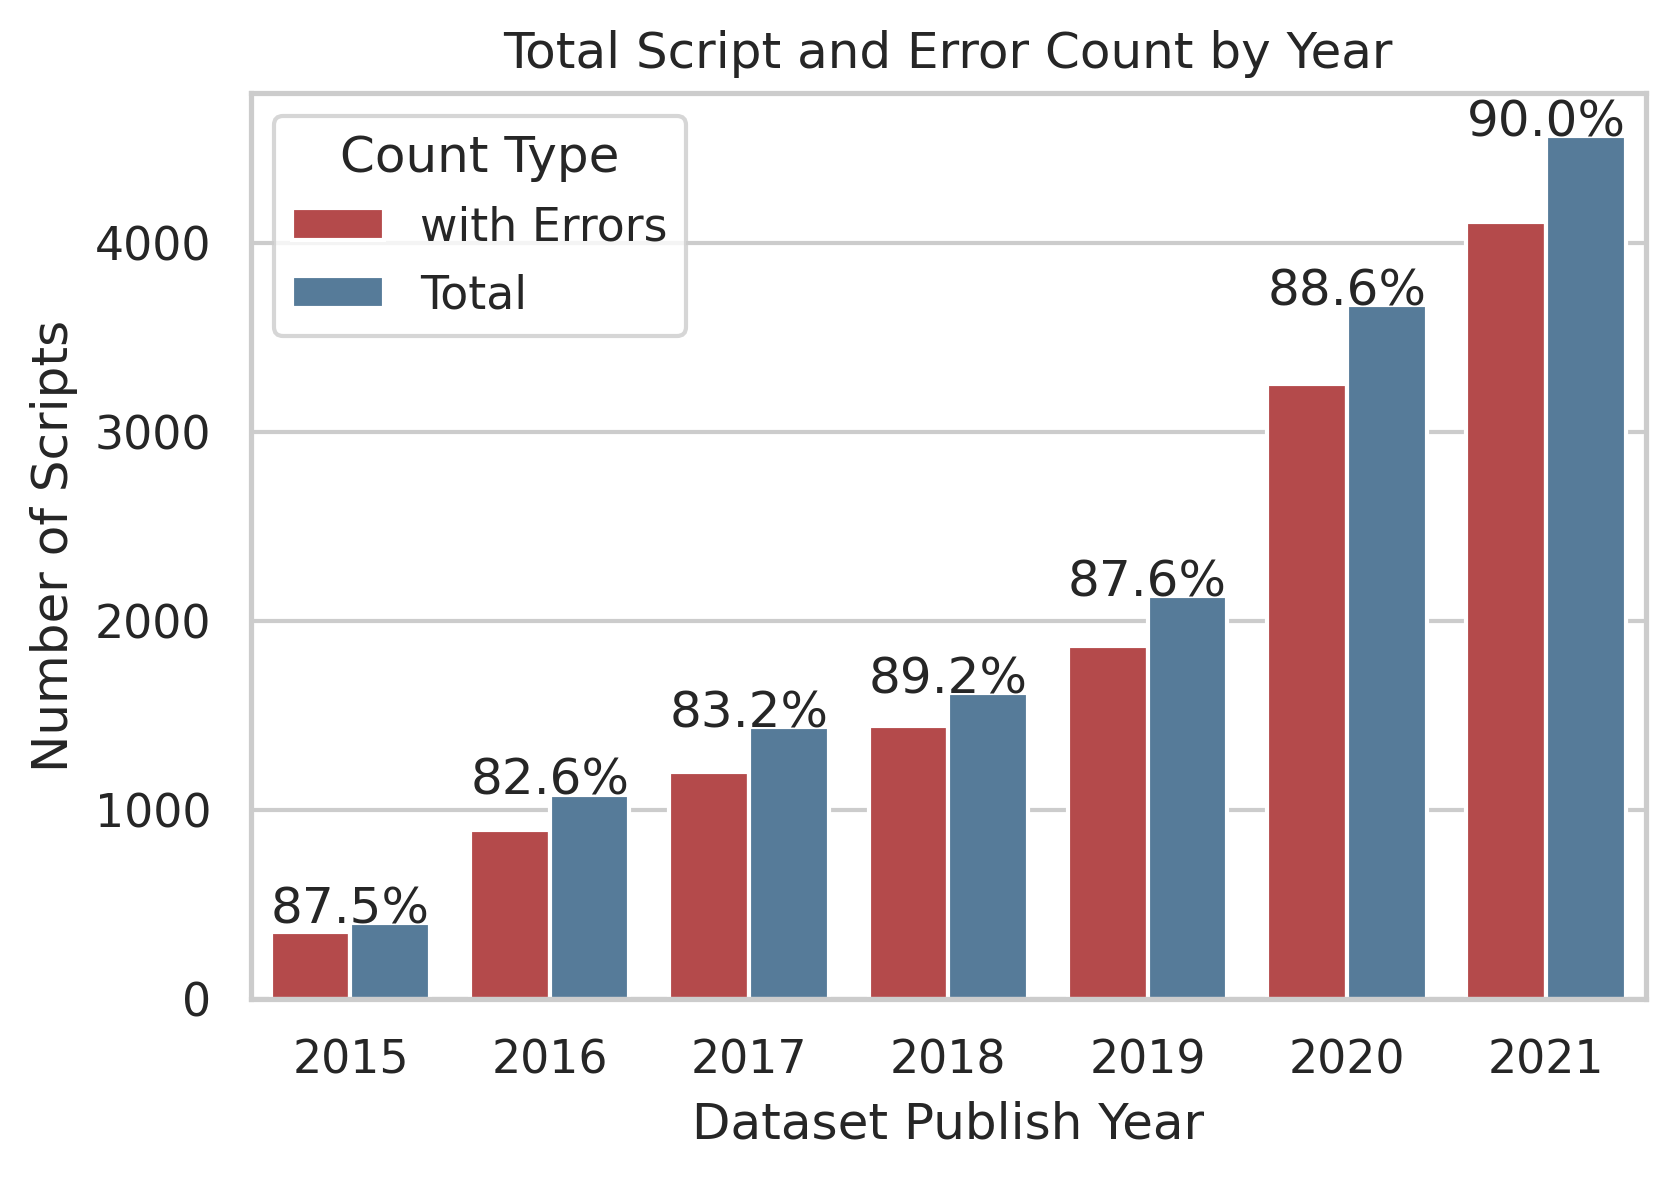

In [13]:
#plt.figure(figsize=(10, 5), dpi=300)
plt.figure(dpi=300)
sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("notebook")
ax = sns.barplot(x="Year", y="Count", hue="Count Type", data=year_melted_df, palette=sns.color_palette("Set1", n_colors=2, desat=.7))
ax.set_title('Total Script and Error Count by Year')
ax.set_xlabel("Dataset Publish Year")
ax.set_ylabel("Number of Scripts")
year_errors_df = year_melted_df[year_melted_df["Count Type"] == "with Errors"]
x_index = 0
for index, row in year_errors_df.iterrows():
    x = row["Year"]
    y = row["Count"]
    total = year_melted_df[year_melted_df["Count Type"] == "Total"]
    total = total[total["Year"] == row["Year"]]
    perc = round(row["Count"] / total["Count"].values[0] * 100, 1)
    ax.text(x=x_index,y=total["Count"].values[0],s=str(perc) + "%", ha="center")
    x_index += 1
#plt.show()
plt.savefig('../figures/error_count_by_year.png', format="png")

__Errors by Subject Plot__

In [14]:
subjects = dataset_df.loc[:, ~dataset_df.columns.isin(['doi', 'year', 'nr_time', 'nr_clean'])].columns

subject_breakdown = {"Subject":[], "Total Files": [], "Total Error Files":[], "Error Rate (Rounded)":[]}
subject_error_percs = {}
for subject in subjects:
    scripts_in_subject = overall_df[overall_df[subject] == True]
    total_files = len(scripts_in_subject.index)
    if(total_files == 0):
        continue
    
    # Not directly used in the figure, but for inserting values into the prose later
    subject_error_percs[subject] = [len(scripts_in_subject[scripts_in_subject.nr_error_category != "success"].index) / len(scripts_in_subject.index) * 100]
    
    subject_breakdown["Subject"].append(subject)
    total_error_files = len(scripts_in_subject[scripts_in_subject["nr_error_category"] != "success"].index)
    subject_breakdown["Total Files"].append(total_files)
    subject_breakdown["Total Error Files"].append(total_error_files)
    subject_breakdown["Error Rate (Rounded)"].append("{0:.4g}".format(total_error_files / total_files * 100))

subject_error_percs.pop("Chemistry")
subject_error_percs = pd.DataFrame(subject_error_percs)
subject_error_desc = subject_error_percs.iloc[0].describe()

subject_breakdown_df = pd.DataFrame(subject_breakdown)    
subject_breakdown_df['Subject'] = pd.Categorical(subject_breakdown_df['Subject'],categories=['Social Sciences',\
                                                           'Computer and Information Science',\
                                                           'Medicine, Health and Life Sciences',\
                                                           'Physics',\
                                                           'Engineering',\
                                                           'Other',\
                                                           'Business and Management',\
                                                           'Mathematical Sciences',\
                                                           'Arts and Humanities',\
                                                           'Agricultural Sciences',\
                                                           'Law',\
                                                           'Earth and Environmental Sciences'],ordered=True)
subject_breakdown_df = subject_breakdown_df.sort_values('Subject',ascending=True)
subject_breakdown_df = subject_breakdown_df[~subject_breakdown_df["Subject"].isna()]

subject_err_df = pd.DataFrame(columns=["Subject", "is_error"])

for _, row in subject_breakdown_df.iterrows():
    num_err = int(row["Total Error Files"])
    num_suc = int(row["Total Files"] - row["Total Error Files"])
    subject_err_df = subject_err_df.append(([pd.DataFrame({"Subject" : [row["Subject"]], "is_error": [0]})] * num_suc))
    subject_err_df = subject_err_df.append(([pd.DataFrame({"Subject" : [row["Subject"]], "is_error": [1]})] * num_err))

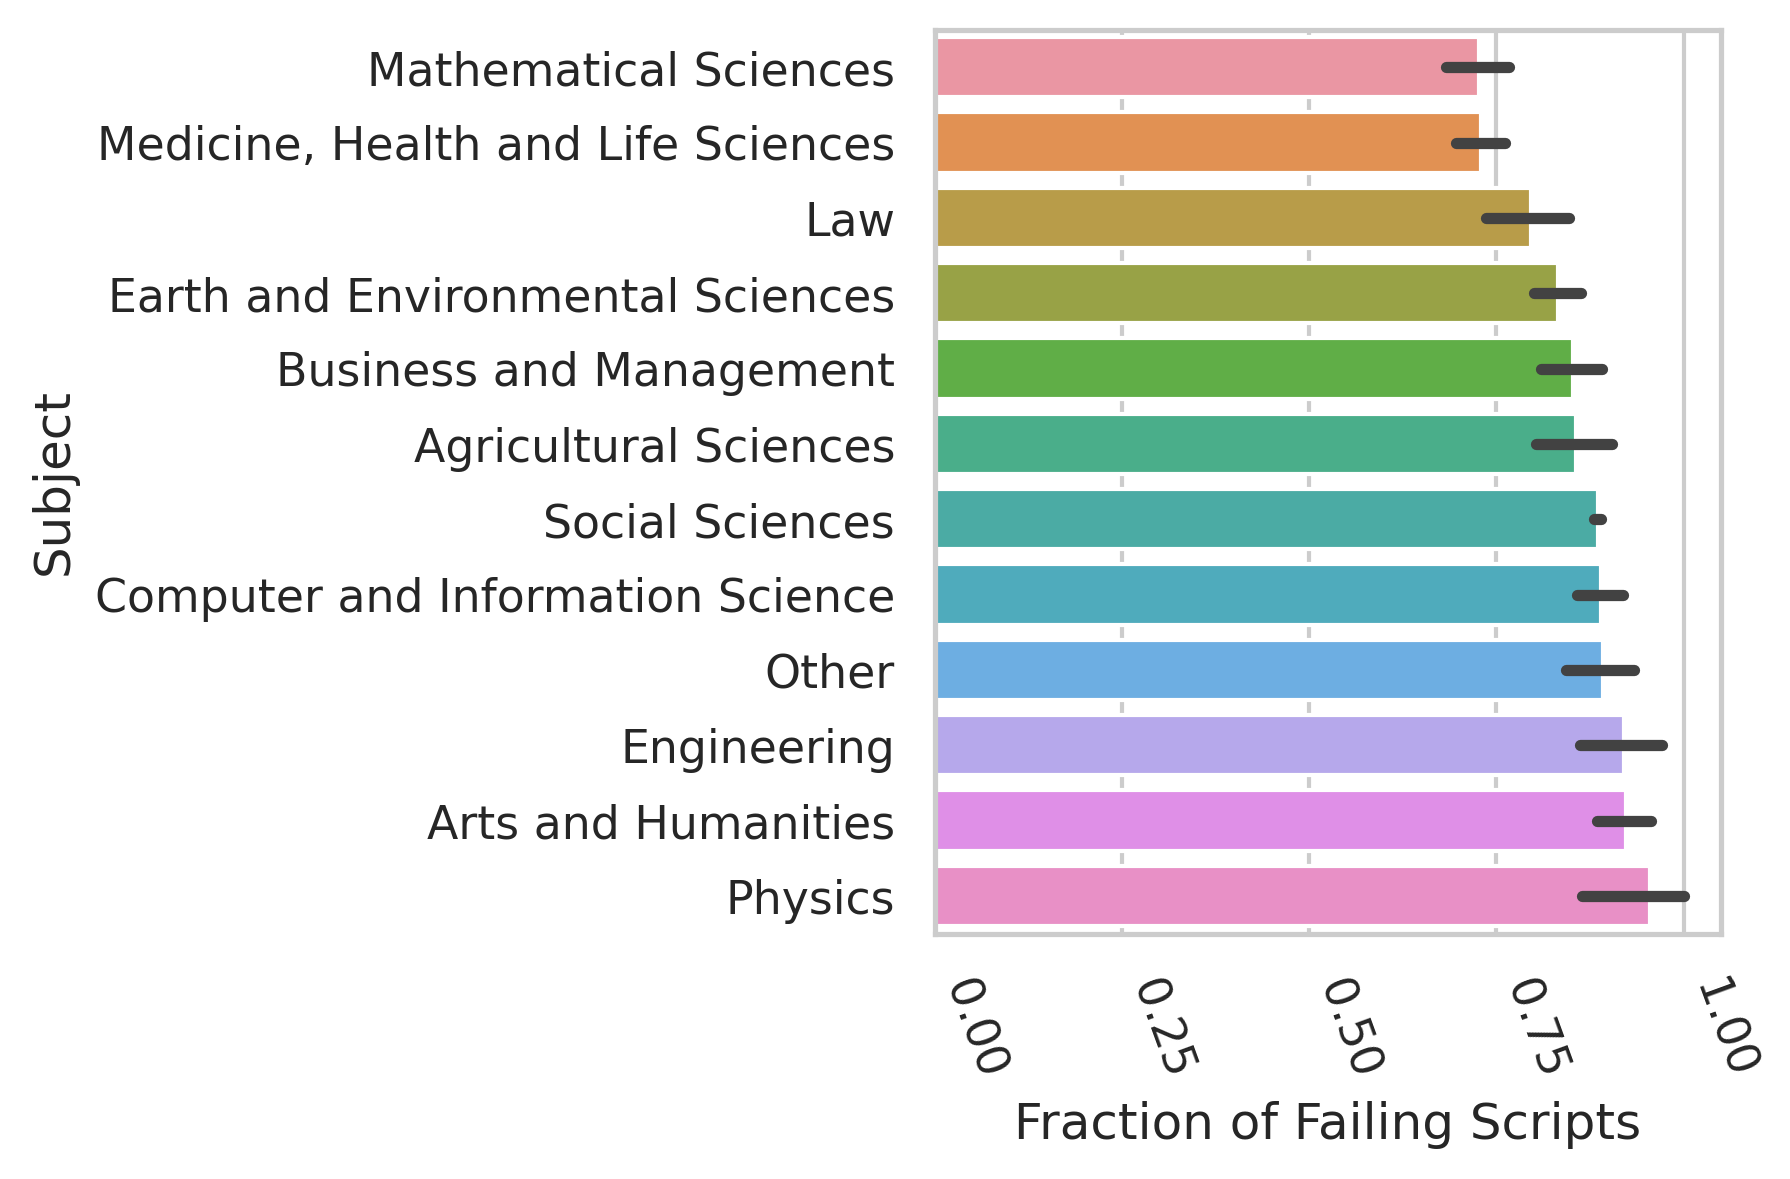

In [15]:
plt.figure(dpi=300)
plt.xticks(rotation=-70, ha = "left")
sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("notebook")
ax = sns.barplot(y=subject_err_df['Subject'], 
                 x=subject_err_df['is_error'],
                order=["Mathematical Sciences", 
                      "Medicine, Health and Life Sciences",
                      "Law",
                      "Earth and Environmental Sciences",
                      "Business and Management",
                      "Agricultural Sciences",
                      "Social Sciences",
                      "Computer and Information Science",
                      "Other",

                      "Engineering",
                      "Arts and Humanities",
                      "Physics"])
#ax.set_title('Script Failure Proportion by Subject')
ax.set_ylabel("Subject")
ax.set_xlabel("Fraction of Failing Scripts")
plt.tight_layout()
#plt.show()
plt.savefig('../figures/error_rate_by_subject.png', format="png")

Analyzing scripts that ran __*with*__ RaaS
=======================================

These scripts executed in a rocker/tidyverse environment, R version 3.6.3, with a time limit of one script per hour, up to five hours per dataset AFTER RaaS processed them.

## Preprocessing 

Our raw data files for RaaS come from the RaaS database, as well as extra information captured and stored during the evaluation, such as information about which datasets timed-out and which failed. Because the evaluation was executed in parallel on multiple cloud VMs, we need to start by coimbining all of the multiple pieces of raw data into processed dataframes. 

To generate the plots and tables used in the paper, we create three dataframes. First is `both_datasets_df`, which stores information at the granularity of datasets that is joined with the previous `dataset_df` containing the not RaaS-processed data. Keeping them in the same dataframe allows us to easily view the effect of processing a dataset through RaaS. Second is `both_scripts_complete_df` which is data at the granularity of scripts, for this dataframe we merge it with the previous `script_df` for easy comparisons. We merge rather than join for this dataframe to easily narrow down to scripts that only executed under both conditions. We also create a version of this exact same dataframe where we join instead of merge to allow us to focus on control or treatment, `both_scripts_all_df`.

In [16]:
# Collect the path to all databases that contain data for datasets evaluated by RaaS
db_files = [y for x in os.walk("../data/raas_dbs") for y in glob(os.path.join(x[0], '*app.db'))]

# List of dataframes to concat later from each database
result_dfs = []

# Convert the dataset table written by RaaS to a dataframe for each database we have and then 
# concat into a single dataframe we will use in the eval
for db_file in db_files:
    con = sqlite3.connect(db_file)
    result_dfs.append(pd.read_sql_query("SELECT report FROM dataset", con))
        
# The final dataframe that contains all of the data from all devices that processed datasets with RaaS
raas_df = pd.concat(result_dfs)

def get_cleanliness_from_report(report):
    report_dict = json.loads(report)
    if len(report_dict["Individual Scripts"]) == 0:
        return None
    scripts_df = pd.DataFrame(report_dict["Individual Scripts"]).transpose()
    scripts_df["Errors"] = scripts_df["Errors"].apply(lambda x: x[0] if x else "success")
    error_set = set(scripts_df["Errors"].values)
    return(len(error_set) == 1 and "success" in error_set)
get_cleanliness_from_report_v = np.vectorize(get_cleanliness_from_report)

def get_nums_scripts_from_report(report):
    report_dict = json.loads(report)
    return len(report_dict["Individual Scripts"])
get_nums_scripts_from_report_v = np.vectorize(get_nums_scripts_from_report)

raas_df["doi"] = get_doi_from_report_v(raas_df["report"].values)
raas_df["raas_time"] = get_time_from_report_v(raas_df["report"].values)
raas_df["raas_clean"] = get_cleanliness_from_report_v(raas_df["report"].values)
raas_df["raas_num_scripts"] = get_nums_scripts_from_report_v(raas_df["report"].values)
raas_df["raas_timed_out"] = False
accidental_duplicated = list(raas_df.doi.value_counts()[raas_df.doi.value_counts() > 1].index)
for duplicate in accidental_duplicated:
    rows = list(raas_df[raas_df.doi == duplicate].index)
    rows.pop(0)
    raas_df = raas_df.drop(rows)

In [17]:
# Collect the path to all files that contain data for datasets timed out when running with RaaS
timeout_doi_file_list = [y for x in os.walk("../data/raas_timeouts") for y in glob(os.path.join(x[0], '*timeout-dois.txt'))]

timeout_dois = []
for timeout_file_path in timeout_doi_file_list:
    with open(timeout_file_path, "r") as timeout_file:
        timeout_dois = timeout_dois + timeout_file.readlines()

timeout_dois = list(set(timeout_dois))
both_datasets_complete_df = dataset_df.merge(raas_df.set_index("doi"), on="doi") 
both_datasets_complete_df = both_datasets_complete_df[~both_datasets_complete_df.nr_clean.isna()]
both_datasets_all_df = dataset_df.join(raas_df.set_index("doi"), on="doi") 

timed_out_col_idx = both_datasets_complete_df.columns.get_loc("raas_timed_out")
timed_out_row_idxs = both_datasets_complete_df[both_datasets_complete_df.doi.isin(strip_newlines_v(timeout_dois))].index
both_datasets_complete_df.loc[timed_out_row_idxs, "raas_timed_out"] = True

timed_out_col_idx = both_datasets_all_df.columns.get_loc("raas_timed_out")
timed_out_row_idxs = both_datasets_all_df[both_datasets_all_df.doi.isin(strip_newlines_v(timeout_dois))].index
both_datasets_all_df.loc[timed_out_row_idxs, "raas_timed_out"] = True

#timed_out_col_idx = both_datasets_df.columns.get_loc("raas_timed_out")
#timed_out_row_idxs = both_datasets_df[both_datasets_df.doi.isin(strip_newlines_v(timeout_dois))].index


In [18]:
raas_scripts_dict = {"raas_error":[], "unique_id" : []}

def get_scripts_info_from_report(report):
    report_dict = json.loads(report)
    if len(report_dict["Individual Scripts"]) < 1:
        #print(report_dict["Additional Information"]["Container Name"])
        return ([], [])
    scripts_temp_df = pd.DataFrame(report_dict["Individual Scripts"]).transpose()
    timed_out_scripts = scripts_temp_df[scripts_temp_df["Timed Out"] == True]
    if(len(timed_out_scripts.index) > 0):
        print(timed_out_scripts)
    #timed_out_idxs = scripts_temp_df
    return(scripts_temp_df.index.values, scripts_temp_df.Errors.values)

for _, row in raas_df.iterrows():
    filenames, errors = get_scripts_info_from_report(row["report"])
    if len(filenames) == len(errors) and len(filenames) != 0:
        raas_scripts_dict["raas_error"] = raas_scripts_dict["raas_error"] + [error if error != [] else "success" for error in errors]
        raas_scripts_dict["unique_id"] = raas_scripts_dict["unique_id"] + list(create_script_id_v([row["doi"]] * len(filenames), filenames))
        #raas_scripts_dict["doi"] = raas_scripts_dict["doi"] + [row["doi"]] * len(filenames)
    else:
        #print(row["doi"])
        pass
    #print(filenames)
    
#[error for error in raas_scripts_dict["error"] if error is not None and len(error) >1]
raas_scripts_dict["raas_error"] = [error[0] if error != "success" else error for error in raas_scripts_dict["raas_error"]]
raas_scripts_df = pd.DataFrame(raas_scripts_dict)
raas_scripts_df["raas_error_category"] = determine_error_cause_v(raas_scripts_df["raas_error"])

both_scripts_complete_df = scripts_df.merge(raas_scripts_df.set_index("unique_id"), on="unique_id")
both_scripts_all_df = scripts_df.join(raas_scripts_df.set_index("unique_id"), on="unique_id")
scripts_datasets_both_complete = both_scripts_all_df[both_scripts_all_df.doi.isin(both_datasets_complete_df.doi)] 

both_no_timeouts = both_datasets_all_df[(both_datasets_all_df["raas_timed_out"] == False) & (both_datasets_all_df["nr_timed_out"] == False)]
#3033


## Comparison of Timeout Information

In [19]:
timed_out_md = '''
-----------------------------------------------------------------------------
    Datasets                                                          Scripts
  ---------- --------------- -------------- ---------------- ----------------
       Total      Control NC   Treatment NC   Both Completed   Both Completed

        TOTAL_DS               DS_TO_WO_RAAS_TOTAL            DS_TO_W_RAAS_TOTAL             DS_BOTH_DONE_TOTAL            SC_BOTH_DONE_TOTAL

        100%            DS_TO_WO_RAAS_PERC%          DS_TO_W_RAAS_PERC%            DS_BOTH_DONE_PERC%          SC_BOTH_DONE_PERC%\*

-----------------------------------------------------------------------------

Table: This table displays the number of datasets that did not complete (NC) during
the evaluations, and the number that completed with and without RaaS.
\*Note that for the number of scripts that completed in both, the
percentage is out of the total number of scripts: TOTAL_SC. The rest of
the percentages are out of the total number of datasets: TOTAL_DS. {#tbl:timeout-results}
'''


def replace_total_perc_table(md, total, percent, key):
    md = md.replace(key + "_TOTAL", str(total))
    md = md.replace(key + "_PERC", str(percent))
    return(md)


total_datasets = len(both_datasets_all_df.index)
num_datasets_without_raas_timed_out = len(both_datasets_all_df[both_datasets_all_df.nr_time.isna() | both_datasets_all_df.nr_timed_out == True].index)
num_datasets_with_raas_timed_out = len(both_datasets_all_df[both_datasets_all_df.raas_time.isna() | both_datasets_all_df.raas_timed_out == True].index)
num_datasets_both_completed = len(both_datasets_all_df[(both_datasets_all_df["raas_timed_out"] == False) & (both_datasets_all_df["nr_timed_out"] == False)].index)

num_scripts_both_completed = len(both_scripts_complete_df.index)
num_total_scripts = len(both_scripts_all_df.index)

timed_out_md = timed_out_md.replace("TOTAL_DS", str(total_datasets))
timed_out_md = timed_out_md.replace("TOTAL_SC", str(num_total_scripts))

timed_out_md = replace_total_perc_table(timed_out_md, num_datasets_without_raas_timed_out, "{0:.1f}".format(num_datasets_without_raas_timed_out / total_datasets * 100), "DS_TO_WO_RAAS")
timed_out_md = replace_total_perc_table(timed_out_md, num_datasets_with_raas_timed_out, "{0:.1f}".format(num_datasets_with_raas_timed_out / total_datasets * 100), "DS_TO_W_RAAS")
timed_out_md = replace_total_perc_table(timed_out_md, num_datasets_both_completed, "{0:.1f}".format(num_datasets_both_completed / total_datasets * 100), "DS_BOTH_DONE")
timed_out_md = replace_total_perc_table(timed_out_md, num_scripts_both_completed, "{0:.1f}".format(num_scripts_both_completed / num_total_scripts * 100), "SC_BOTH_DONE")

write_file_from_string("timed_out_comparisons.md", timed_out_md)

## Success Rates Comparisons 

In [20]:
success_rates_md = '''
----------------------------------------------------------------------------
                              Scripts                   Datasets 
  -------------------- -------------- ----------- -------------- -----------
                         Without RaaS   With RaaS   Without RaaS   With RaaS

  Total                          SC_WO_RAAS_TOTAL      SC_W_RAAS_TOTAL           DS_WO_RAAS_TOTAL        DS_W_RAAS_TOTAL

  Successful                     SC_WO_RAAS_GOOD        SC_W_RAAS_GOOD            DS_WO_RAAS_GOOD         DS_W_RAAS_GOOD

  Error                          SC_WO_RAAS_BAD        SC_W_RAAS_BAD           DS_WO_RAAS_BAD        DS_W_RAAS_BAD

  Percent Successful            SC_WO_RAAS_PERC%       SC_W_RAAS_PERC%           DS_WO_RAAS_PERC%       DS_W_RAAS_PERC%

----------------------------------------------------------------------------
'''

def replace_success_rate_table(success_rates_md, total, good, key):
    success_rates_md = success_rates_md.replace(key + "_TOTAL", str(total))
    success_rates_md = success_rates_md.replace(key + "_GOOD", str(good))
    success_rates_md = success_rates_md.replace(key + "_BAD", str(total - good))
    success_rates_md = success_rates_md.replace(key + "_PERC", "{0:.1f}".format(good / total * 100))
    return(success_rates_md)

scripts_wo_raas = scripts_datasets_both_complete[~scripts_datasets_both_complete.nr_error.isna()]
scripts_w_raas = scripts_datasets_both_complete[~scripts_datasets_both_complete.raas_error.isna()]

success_rates_md = replace_success_rate_table(success_rates_md, len(scripts_wo_raas.index), len(scripts_wo_raas[scripts_wo_raas["nr_error"] == "success"].index), "SC_WO_RAAS")
success_rates_md = replace_success_rate_table(success_rates_md, len(scripts_w_raas.index), len(scripts_w_raas[scripts_w_raas["raas_error"] == "success"].index), "SC_W_RAAS")

success_rates_md = replace_success_rate_table(success_rates_md, len(both_datasets_complete_df.index), len(both_datasets_complete_df[both_datasets_complete_df.nr_clean].index), "DS_WO_RAAS")
success_rates_md = replace_success_rate_table(success_rates_md, len(both_datasets_complete_df.index), len(both_datasets_complete_df[both_datasets_complete_df.raas_clean].index), "DS_W_RAAS")

write_file_from_string("success_rates_comparisons.md", success_rates_md)

## Error Categories Comparison

In [21]:
error_categories_md = '''
------------------------------------------------------------
                        containR              RaaS 
  ------------------- ---------- --------- ------- ---------
  Error Type               Count   Percent   Count   Percent

  Library                      8      0.3%    LIB_TOTAL    LIB_PERC%

  Working directory           12      0.5%      WD_TOTAL     WD_PERC%

  Missing file              1400     61.8%    MF_TOTAL    MF_PERC%

  Function                    NA        NA     F_TOTAL    F_PERC%

  Other                      847     37.4%    OT_TOTAL    OT_PERC%

  Total Failures            2329              ALL_TOTAL 

------------------------------------------------------------
'''

def replace_error_category(precision, category, key, raas_error_scripts):
    return(replace_total_perc_table(error_categories_md, 
                             len(raas_error_scripts[raas_error_scripts.raas_error_category == category].index), 
                             precision.format(len(raas_error_scripts[raas_error_scripts.raas_error_category == category].index) / total_raas_errors * 100), 
                             key))

raas_error_scripts = raas_scripts_df[raas_scripts_df.raas_error != "success"]
total_raas_errors = len(raas_error_scripts.index)
error_categories_md = error_categories_md.replace("ALL_TOTAL", str(total_raas_errors))

error_categories_md = replace_error_category("{0:.1f}", "library", "LIB", raas_error_scripts)
error_categories_md = replace_error_category("{0:.1f}", "working directory", "WD", raas_error_scripts)
error_categories_md = replace_error_category("{0:.1f}", "missing file", "MF", raas_error_scripts)
error_categories_md = replace_error_category("{0:.1f}", "function", "F", raas_error_scripts)
error_categories_md = replace_error_category("{0:.1f}", "other", "OT", raas_error_scripts)


write_file_from_string("error_categories_comparisons.md", error_categories_md)

In [22]:
error_change_df = pd.crosstab(index=both_scripts_complete_df["nr_error_category"], columns=both_scripts_complete_df["raas_error_category"])
if("timed out" not in error_change_df):
    error_change_df["timed out"] = np.repeat([0], len(error_change_df))
error_change_df.reindex(["library", "working directory", "missing file", "function", "other", "timed out", "success"])[["library", "working directory", "missing file", "function", "other", "success"]]

# Once the data is there, mess with the markdown to get the right format
error_change_md = error_change_df.to_markdown()
error_change_md = error_change_md.replace("|", " ")
error_change_md = error_change_md.replace(":", "-")
error_change_list = error_change_md.split("\n")
error_change_list[0], error_change_list[1] = error_change_list[1], error_change_list[0]
#error_change_list[1] = "     " + error_change_list[1]
error_change_list.insert(2, "  **Pre-RaaS**\n")

list_idxs = list(range(0, len(error_change_list)))
list_idxs.reverse()

for idx in list_idxs:
    if(idx != list_idxs[-1]): 
        error_change_list[idx] = error_change_list[idx][:19] + "     " + error_change_list[idx][19:]
    error_change_list.insert(idx, " ")

error_change_list.append(" ")
print(error_change_list.pop(2))
error_change_md = "\n".join(error_change_list)
error_change_md = '''
--------------------------------------------------------------------------------------------------------------
                           **Post-RaaS**                                                                 ''' + error_change_md

error_change_md = error_change_md + \
'''
--------------------------------------------------------------------------------------------------------------
'''

error_change_md = error_change_md[:220] + "----" + error_change_md[220:]
error_change_md = error_change_md[:349] + "                 " + error_change_md[366:]

write_file_from_string("error_change_table.md", error_change_md)

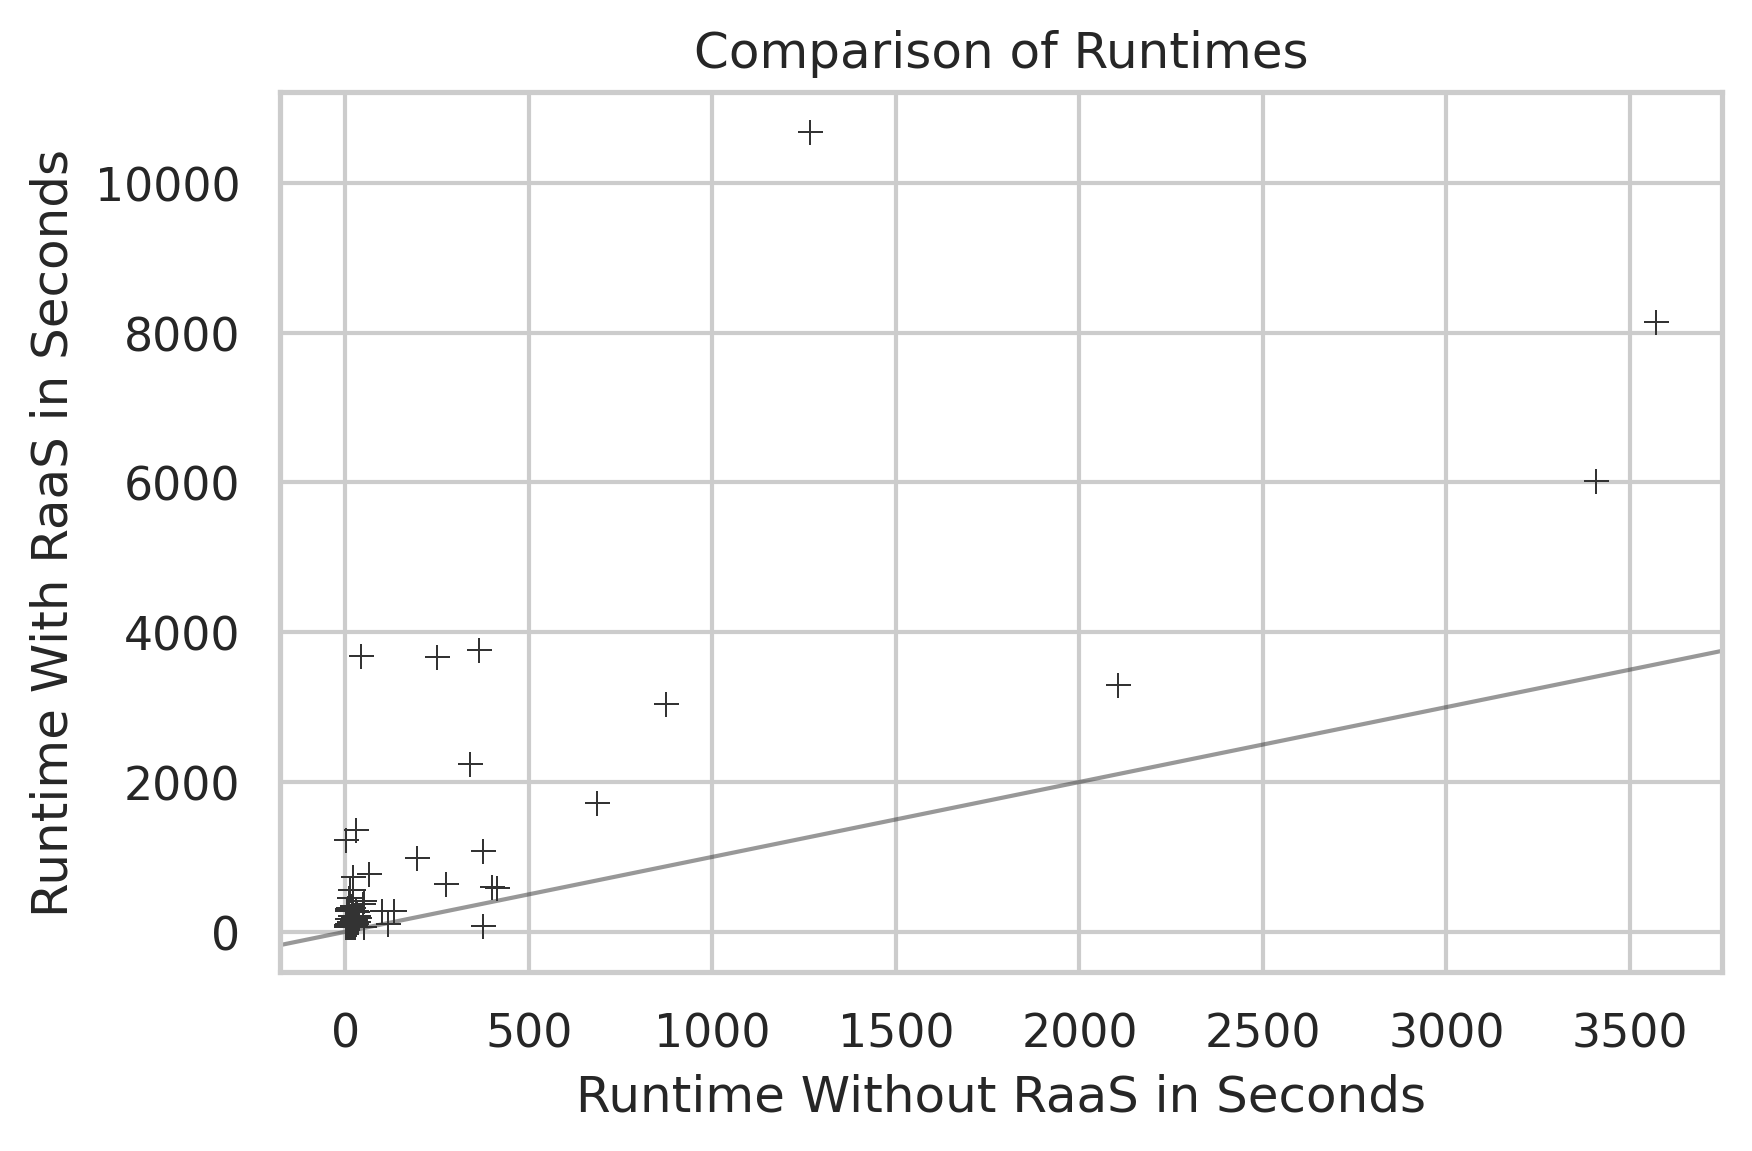

In [23]:
all_clean_completed_datasets_df = both_datasets_complete_df[both_datasets_complete_df.nr_clean & both_datasets_complete_df.raas_clean]
#print(len(all_clean_completed_datasets_df.index))
#plt.figure(figsize=(10, 5), dpi=300)
plt.figure(dpi=300)
sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("notebook")
ax = sns.scatterplot(x="nr_time", y="raas_time", data=all_clean_completed_datasets_df, color = ".2", marker ="+")
ax.set_title('Comparison of Runtimes')
ax.set_xlabel("Runtime Without RaaS in Seconds")
ax.set_ylabel("Runtime With RaaS in Seconds")
plt.tight_layout()
ax.axline([0, 0], [1, 1], linewidth=1, alpha = 0.5, color = "0.2")
#plt.show()
plt.savefig('../figures/runtime-comparison.png', format="png")


## Individual Values Used in the Paper

In [24]:
#r_file_query = "name:renv.lock"
#api_url="https://dataverse.harvard.edu/api/search/"
#lock_results = requests.get(api_url, params= {"q": r_file_query, "type": "file", "start":"0", "per_page":"100"}).json()
#with open("../data/lockfiles_on_dataverse_2022_06_16.json", "w+") as lockfile_json:
#    json.dump(lock_results, lockfile_json)

with open("../data/lockfiles_on_dataverse_2022_06_16.json", "r") as lockfile_json:
    lockfile_data = json.load(lockfile_json)
write_file_from_string("lockfiles.md", str(lockfile_data["data"]["total_count"]))

with open("../data/r_dois.txt", "r") as dois_txt:
    r_dois = dois_txt.readlines()
write_file_from_string("num_of_datasets.md", str(len(r_dois)))

write_file_from_string("num_successful_scripts_noraas.md", "{0:.1f}%".format(num_success_scripts / total_num_scripts * 100))

write_file_from_string("num_successful_datasets_noraas.md", str(len(dataset_df[dataset_df.nr_clean].index)))

write_file_from_string("perc_successful_datasets_noraas.md", "{0:.1f}%".format(len(dataset_df[dataset_df.nr_clean].index) / len(dataset_df.index) * 100))

write_file_from_string("perc_library_errors_noraas.md", "{0:.1f}%".format(len(scripts_df[scripts_df["nr_error_category"] == 'library'].index) / num_error_scripts * 100))

physics_df = overall_df[~overall_df.Physics.isna()]
physics_df = physics_df[physics_df.Physics]
write_file_from_string("number_of_physics_scripts.md", str(len(physics_df.index)))

#write_file_from_string("num_of_both_clean_datasets.md", str(len(all_clean_completed_datasets_df.index)))

#write_file_from_string("num_of_both_completed_datasets.md", str(num_datasets_both_completed))
#write_file_from_string("num_of_both_completed_scripts.md", str(num_scripts_both_completed))

scripts_in_datasets_both_completed = both_scripts_all_df[both_scripts_all_df.doi.isin(both_no_timeouts.doi)]
scripts_sourced = scripts_in_datasets_both_completed[scripts_in_datasets_both_completed.raas_error.isna()]
num_of_success_source_scripts = len(scripts_sourced[scripts_sourced.nr_error_category == "success"].index)
perc_success_sourced_in_raas = num_of_success_source_scripts / len(both_scripts_complete_df[both_scripts_complete_df.nr_error_category == "success"].index) * 100
write_file_from_string("num_of_success_source_scripts.md", str(num_of_success_source_scripts))
write_file_from_string("perc_success_sourced_in_raas.md", "{0:.1f}%".format(perc_success_sourced_in_raas))

success_increase = "{0:.3g}x".format(len(both_scripts_complete_df[both_scripts_complete_df.raas_error_category == "success"]) / len(both_scripts_complete_df[both_scripts_complete_df.nr_error_category == "success"]))
write_file_from_string("success_increase.md", success_increase)

clean_raas_datasets = len(both_datasets_complete_df[both_datasets_complete_df.raas_clean == True].index)
clean_nr_datasets = len(both_datasets_complete_df[both_datasets_complete_df.nr_clean == True].index)

write_file_from_string("nr_raas_clean_dataset_increase.md","{0:.3g}x".format(clean_raas_datasets / clean_nr_datasets))
write_file_from_string("clean_raas_datasets.md", str(clean_raas_datasets))
write_file_from_string("perc_clean_raas_datasets.md", "{0:.1f}%".format(clean_raas_datasets / len(both_datasets_all_df[~both_datasets_all_df.raas_time.isna()].index) * 100))

write_file_from_string("library_to_success.md", str(error_change_df.loc["library"]["success"]))

def find_perc_change(cat_from, cat_to):
    return(error_change_df.loc[cat_from][cat_to] / sum(error_change_df.loc[cat_from]) * 100)

def write_perc_change(filename, cat_from, cat_to):
    write_file_from_string(filename, "{0:.1f}%".format(find_perc_change(cat_from, cat_to)))

def find_perc_diff(category):
    return((sum(error_change_df.loc[category]) - error_change_df.loc[category][category]) / sum(error_change_df.loc[category]) * 100)

def write_perc_diff(filename, category):
    write_file_from_string(filename, "{0:.1f}%".format(find_perc_diff(category)))
    
write_perc_change("perc_library_fixed.md", cat_from = "library", cat_to = "success")
write_perc_change("perc_wd_fixed.md", cat_from = "working directory", cat_to = "success")
write_perc_change("perc_mf_fixed.md", cat_from = "missing file", cat_to = "success")
write_perc_change("mf_no_change.md", cat_from = "missing file", cat_to = "missing file")
write_perc_change("perc_other_fixed.md", cat_from = "other", cat_to = "success")

write_perc_diff("perc_library_not_repeated.md", "library")
write_perc_diff("perc_wd_not_repeated.md", "working directory")

write_file_from_string("library_to_success.md", str(error_change_df.loc["library"]["success"]))

write_file_from_string("min_subject_perc.md", "{0:.1f}%".format(subject_error_desc["min"]))
write_file_from_string("max_subject_perc.md", "{0:.1f}%".format(subject_error_desc["max"]))

raas_library_errors = both_scripts_all_df[both_scripts_all_df.raas_error_category == "library"]
def get_package_name_from_error(error_msg):
    package_match = re.search("\‘(.+)\’", error_msg)
    if(package_match):
        package_match = package_match.group(1)
    return package_match
get_package_name_from_error_v = np.vectorize(get_package_name_from_error)
packages_not_loaded = get_package_name_from_error_v(raas_library_errors.raas_error)

write_file_from_string("len_set_not_loaded_packages.md", str(len(set(packages_not_loaded))))

write_file_from_string("missing_file_perc_control.md", "{0:.1f}%".format(len(scripts_df[scripts_df["nr_error_category"] == "missing file"].index) / num_error_scripts * 100))
write_file_from_string("missing_file_perc_treat.md", "{0:.1f}%".format(len(raas_error_scripts[raas_error_scripts.raas_error_category == "missing file"].index) / total_raas_errors * 100))

In [25]:
other_to_success = both_scripts_all_df[(both_scripts_all_df.nr_error_category == "other") & (both_scripts_all_df.raas_error_category == "success")] 
def get_missing_objects_errors(error_msg):
    if(re.search("object.+not found", error_msg)):
        return error_msg
    else:
        return None
get_missing_objects_errors_v = np.vectorize(get_missing_objects_errors)

missing_object_msgs = set(get_missing_objects_errors_v(other_to_success.nr_error))
missing_object_msgs.remove(None)

write_file_from_string("miss_obj_to_success.md", str(len(missing_object_msgs)))

In [26]:
def get_devoff_errors(error_msg):
    if(re.search("dev.off()", error_msg)):
        return True
    else:
        return None
get_devoff_errors_v = np.vectorize(get_devoff_errors)

success_to_error = both_scripts_all_df[(both_scripts_all_df.nr_error_category == "success") & (both_scripts_all_df.raas_error_category != "success")] 
success_to_error = success_to_error[~success_to_error.raas_error_category.isna()]
success_to_error_rdtLite_errors = len(success_to_error[(get_devoff_errors_v(success_to_error.raas_error)) | (success_to_error.raas_error == "rdtLite Error")])
success_to_error_noRdtLite = success_to_error[~((get_devoff_errors_v(success_to_error.raas_error)) | (success_to_error.raas_error == "rdtLite Error"))]
success_to_error_mf_errors = len(success_to_error_noRdtLite[success_to_error_noRdtLite.raas_error_category == "missing file"])
success_to_error_func_errors = len(success_to_error_noRdtLite[success_to_error_noRdtLite.raas_error_category == "function"])
success_to_error_other_errors = len(success_to_error_noRdtLite[success_to_error_noRdtLite.raas_error_category == "other"])


write_file_from_string("num_success_to_error.md", str(len(success_to_error)))
write_file_from_string("success_to_error_rdtLite_errors.md", str(success_to_error_rdtLite_errors))
write_file_from_string("success_to_error_mf_errors.md", str(success_to_error_mf_errors))
write_file_from_string("success_to_error_func_errors.md", str(success_to_error_func_errors))
write_file_from_string("success_to_error_other_errors.md", str(success_to_error_other_errors))

write_file_from_string("perc_successful_scripts_raas.md", "{0:.1f}%".format(len(scripts_w_raas[scripts_w_raas["raas_error"] == "success"].index) / len(scripts_w_raas.index) * 100))
write_file_from_string("perc_successful_scripts_noraas.md", "{0:.1f}%".format(len(scripts_wo_raas[scripts_wo_raas["nr_error"] == "success"].index) / len(scripts_wo_raas.index) * 100))

write_file_from_string("perc_error_scripts_raas.md", "{0:.1f}%".format(len(scripts_w_raas[scripts_w_raas["raas_error"] != "success"].index) / len(scripts_w_raas.index) * 100))

write_file_from_string("perc_easily_fixed.md", "{0:.1f}%".format(((error_change_df.success["library"] + error_change_df.success["working directory"]) / len(both_scripts_complete_df[both_scripts_complete_df.nr_error_category != "success"])) * 100))

example_other_error_idxs = [22, 102, 362]
list_of_example_other_errors = ''.join(["- " + ex_error + "\n" for ex_error in list(raas_error_scripts[raas_error_scripts.raas_error_category == "other"].raas_error.iloc[example_other_error_idxs])])
write_file_from_string("list_of_example_other_errors.md", list_of_example_other_errors)

write_file_from_string("faster_with_raas_datasets.md", str(len(all_clean_completed_datasets_df[all_clean_completed_datasets_df.raas_time < all_clean_completed_datasets_df.nr_time])))

write_file_from_string("library_version_loaded.md", raas_library_errors.loc[9002].raas_error.strip("\n"))

In [27]:
error_cats = ["library", "working directory", "missing file", "function", "other", "success"]

total_error = 0
repeat_errors = 0

for error_category in error_cats:
    total_error += sum(error_change_df.loc[:, error_change_df.columns != 'success'].loc[error_category])
    
# We don't care about scripts that stayed a success
error_cats.remove('success')

for error_category in error_cats:
    repeat_errors += error_change_df.loc[error_category, error_category]

write_file_from_string("perc_errors_not_repeated.md", "{0:.1f}%".format((total_error - repeat_errors) / total_error * 100))

# ========================================

## Dataset Level 

In [37]:
dataset_level_md = '''
---------------------------------------------
                          Control   Treatment                                               
  --------------------- --------- -----------
     Percent Successful      CTRL_SUCCESS       TREAT_SUCCESS  
     
      Percent Timed-out      CTRL_TIMEOUT        TREAT_TIMEOUT
   
---------------------------------------------

Table: This table displays the percentage of dataset errors and timeouts out of all TOTAL_DS runnable datasets. Our control is running scripts without RaaS, and our treatment is running scripts with RaaS. {#tbl:dataset-level-fraction}
'''


runnable_datasets = len(both_datasets_all_df.index)

num_datasets_without_raas_errored = len(both_datasets_all_df[(both_datasets_all_df.nr_clean == True)].index)
num_datasets_with_raas_errored = len(both_datasets_all_df[(both_datasets_all_df.raas_clean == True)].index)

num_datasets_without_raas_timeout = len(both_datasets_all_df[(both_datasets_all_df.nr_timed_out) | (both_datasets_all_df.nr_time > 18000)])
num_datasets_with_raas_timeout = len(both_datasets_all_df[(both_datasets_all_df.raas_timed_out) | (both_datasets_all_df.raas_time > 18000)])

dataset_level_md = dataset_level_md.replace("CTRL_SUCCESS", "{0:.1f}%".format(num_datasets_without_raas_errored / runnable_datasets * 100))
dataset_level_md = dataset_level_md.replace("TREAT_SUCCESS", "{0:.1f}%".format(num_datasets_with_raas_errored / runnable_datasets * 100))

dataset_level_md = dataset_level_md.replace("CTRL_TIMEOUT", "{0:.1f}%".format(num_datasets_without_raas_timeout / runnable_datasets * 100))
dataset_level_md = dataset_level_md.replace("TREAT_TIMEOUT", "{0:.1f}%".format(num_datasets_with_raas_timeout / runnable_datasets * 100))

dataset_level_md = dataset_level_md.replace("TOTAL_DS", str(runnable_datasets))



write_file_from_string("dataset_level_table.md", dataset_level_md)
write_file_from_string("runnable_datasets.md", str(runnable_datasets))

## Script Level 

In [38]:
script_level_md = '''
--------------------------------------------------------------------------------------------------------
                          Control   Treatment   Chen Control   Chen Treatment       Trisovic et al. Best                                              
  --------------------- --------- -----------  ------------- ----------------  -------------------------  
     Percent Successful     CTRL_SUCCESS       TREAT_SUCCESS          CHEN_SUCCESS            CHEN_TREAT                      TRIS_BEST
     
      Percent Timed out      CTRL_TO        TREAT_TO        Unknown          Unknown                      TRIS_TO

--------------------------------------------------------------------------------------------------------

Table: This table displays the percentage of runnable scripts that produced errors with and without RaaS. {#tbl:script-level-fraction}
'''

#Values taken from Chen's thesis results
chen_control_successful = 408 / 2839 * 100
# The 408 + 62 is derived from control table stating 408 were successful, and treatment table stating 62 scripts' errors were fixed
chen_treatment_successful = (408 + 62) / 2839 * 100

# Values taken from @trisovic2022largescale referenced in paper
# Total files from 'best of both' is 8609
# Successes from from 'best of both' is 1581
# Time outs from 'best of both' is 5790
tris_best_success = 1581 / 8609 * 100
tris_best_timeouts = 5790 / 8609 * 100

runnable_scripts = len(both_scripts_all_df)
num_scripts_without_raas_successful = len(both_scripts_all_df[both_scripts_all_df.nr_error == "success"].index)
num_scripts_with_raas_successful = len(both_scripts_all_df[both_scripts_all_df.raas_error == "success"].index)
num_scripts_without_raas_timedout = len(both_scripts_all_df[both_scripts_all_df.nr_error_category == "timed out"].index)
num_scripts_with_raas_timedout = len(both_scripts_all_df[both_scripts_all_df.raas_error_category == "timed out"].index)

# Fraction successful inserts
script_level_md = script_level_md.replace("CTRL_SUCCESS", "{0:.1f}%".format(num_scripts_without_raas_successful / runnable_scripts * 100))
script_level_md = script_level_md.replace("TREAT_SUCCESS", "{0:.1f}%".format(num_scripts_with_raas_successful / runnable_scripts * 100))
script_level_md = script_level_md.replace("CHEN_SUCCESS", "{0:.1f}%".format(chen_control_successful))
script_level_md = script_level_md.replace("CHEN_TREAT", "{0:.1f}%".format(chen_treatment_successful))
script_level_md = script_level_md.replace("TRIS_BEST", "{0:.1f}%".format(tris_best_success))

# Fraction Timed-out inserts
script_level_md = script_level_md.replace("CTRL_TO", "{0:.1f}%".format(num_scripts_without_raas_timedout / runnable_scripts * 100))
script_level_md = script_level_md.replace("TREAT_TO", "{0:.1f}%".format(num_scripts_with_raas_timedout / runnable_scripts * 100))
script_level_md = script_level_md.replace("TRIS_TO", "{0:.1f}%".format(tris_best_timeouts))



write_file_from_string("script_level_table.md", script_level_md)
write_file_from_string("runnable_scripts.md", str(runnable_scripts))

In [30]:
sankey_input_intro = []
sankey_input_body = []
sankey_colors = '''
:Success  #00CC00  << 
:Library  Error #0033cc <<
:Library Error #0033cc <<
:Function  Error #cccc00 <<
:Function Error #cccc00 <<
:Missing  File #cc0033 <<
:Missing File #cc0033 <<
:Other  Error #cc6600 <<
:Other Error #cc6600 <<
:Working  Directory #cc00cc <<
:Working Directory #cc00cc <<
'''

def get_sankey_node(node_name, extra_space = ""):
    if node_name in ["library", "function", "other"]:
        node_name = node_name.title() + extra_space + " Error"
    elif node_name in ["working directory", "missing file", "timed out", "missing object"]:
        nodes = node_name.title().split(" ")
        node_name = nodes[0] + " " + extra_space + nodes[1]
    else:
        node_name = node_name.title()
    return(node_name)

for index, row in error_change_df.iterrows():
    if sum(row) > 0:
        sankey_line = "R files [" + str(sum(row)) + "] " + get_sankey_node(index)
        sankey_input_intro.append(sankey_line)
    
    for name, values in row.iteritems():
        if values > 0 and index != "success":
            sankey_input_body.append(get_sankey_node(index) + " [" + str(values) + "] " + get_sankey_node(name, " "))
    sankey_input_body.append("")
sankey_input_intro.append("\n")

# To be used with sankeymatic.com/build
# Dimensions chosen: width 700 height 376
write_file_from_string("sankey_input.txt", '\n'.join(sankey_input_intro)  + '\n'.join(sankey_input_body) + sankey_colors) 

In [31]:
# Massage the data into the format used for plotting
years = set(dataset_df["year"].values)
raas_year_and_err_category_df = both_scripts_all_df.join(dataset_df.set_index("doi"), on ="doi")[["raas_error_category", "year", "doi"]]
plot_years_df = scripts_df.join(raas_year_and_err_category_df.set_index("doi"), on="doi")[["nr_error_category", "raas_error_category", "year", "doi"]]
year_breakdown = {"Year":[], "Total Files": [], "Total Error Files":[], "Error Rate (Rounded)":[]}
for year in years:
    scripts_in_year = plot_years_df[plot_years_df["year"] == year]
    total_files = len(scripts_in_year.index)
    if(total_files == 0):
        continue
        
    year_breakdown["Year"].append(str(year))
    total_error_files = len(scripts_in_year[scripts_in_year["nr_error_category"] != "success"].index)
    year_breakdown["Total Files"].append(total_files)
    year_breakdown["Total Error Files"].append(total_error_files)
    year_breakdown["Error Rate (Rounded)"].append("{0:.4g}".format(total_error_files / total_files * 100))
year_breakdown_df = pd.DataFrame(year_breakdown)
year_breakdown_df.sort_values(["Year"], inplace=True)

year_breakdown_df.columns = ["Year", "Total", "with Errors", "Error Rate"]
year_melted_df = year_breakdown_df[["Year", "with Errors", "Total"]]\
    .loc[year_breakdown_df['Year'].isin(["2015","2016", "2017", "2018", "2019", "2020", "2021",])]\
    .melt(id_vars='Year').rename(columns=str.title)
year_melted_df.columns = ["Year", "Count Type", "Count"]

In [32]:
year_melted_df

,Year,Count Type,Count
0,2015,with Errors,5686
1,2016,with Errors,8748
2,2017,with Errors,14872
3,2018,with Errors,15366
4,2019,with Errors,31378
5,2020,with Errors,60784
6,2021,with Errors,67164
7,2015,Total,6269
8,2016,Total,11080
9,2017,Total,18121


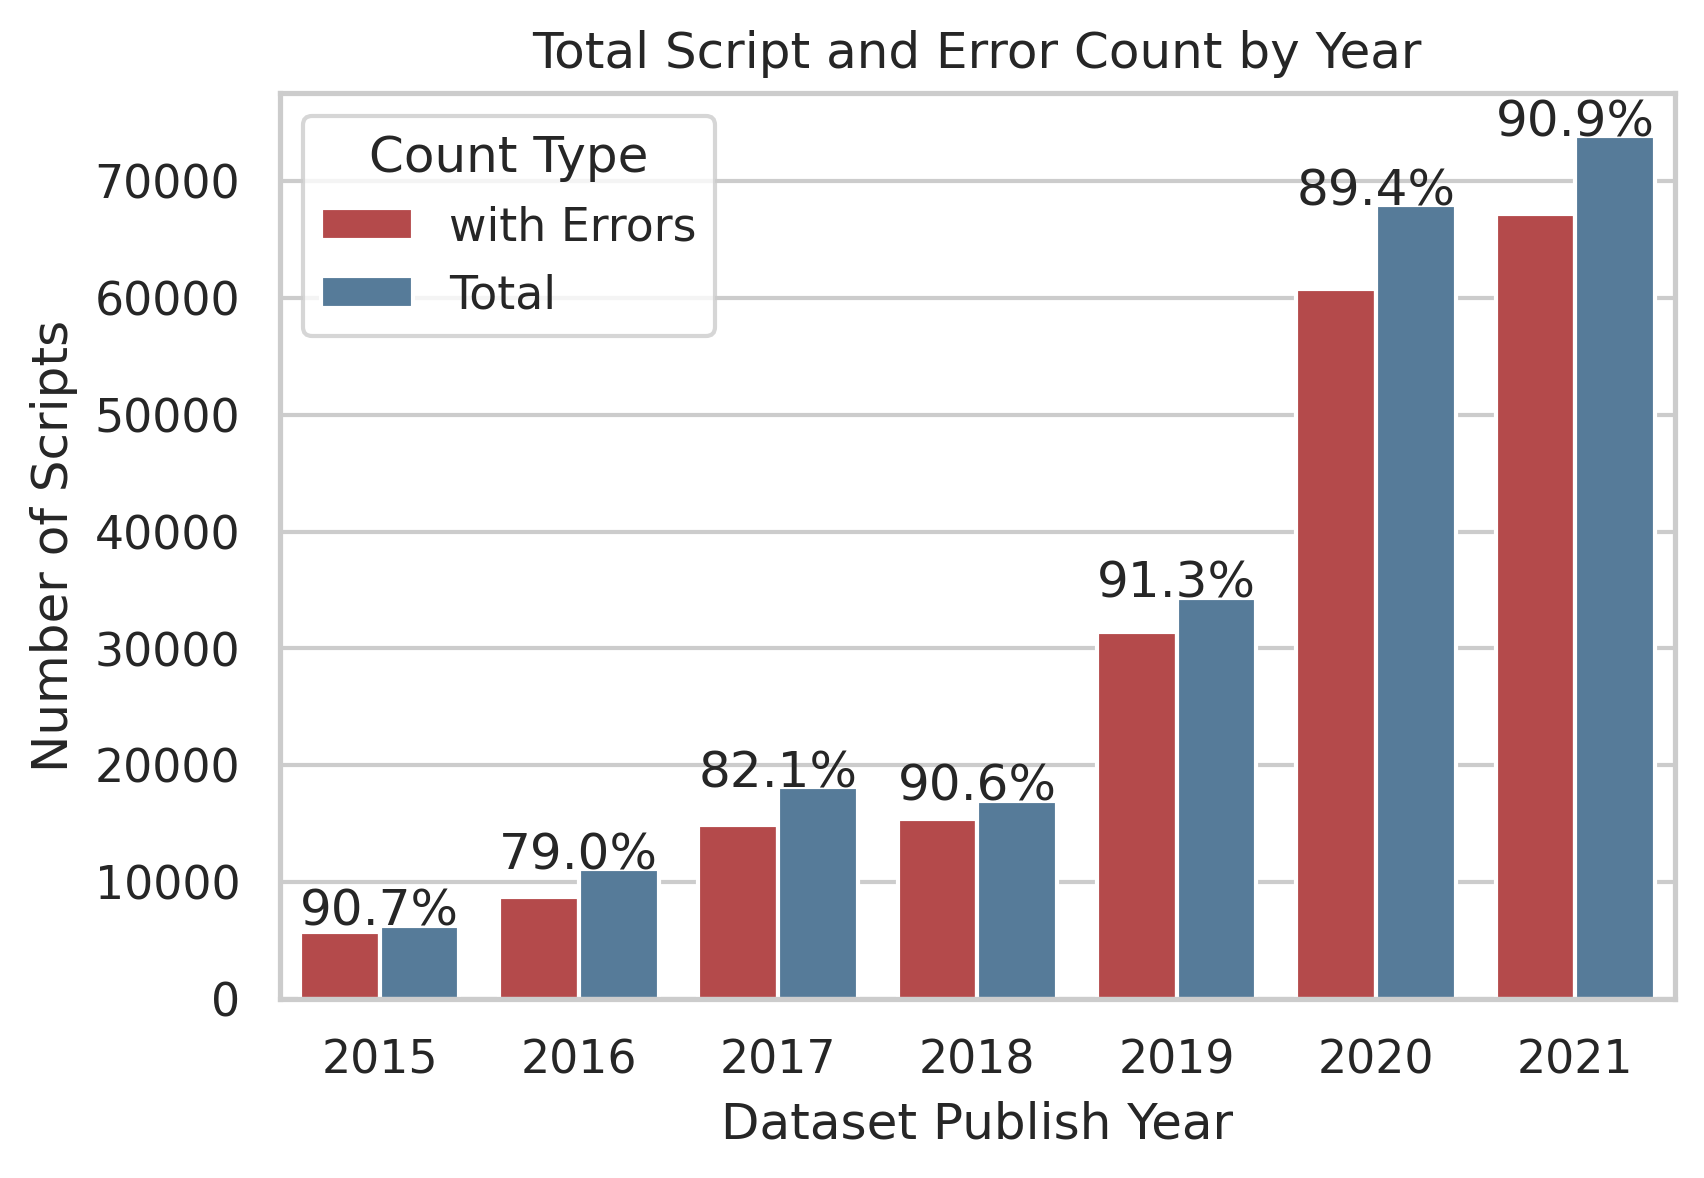

In [33]:
#plt.figure(figsize=(10, 5), dpi=300)
plt.figure(dpi=300)
sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("notebook")
ax = sns.barplot(x="Year", y="Count", hue="Count Type", data=year_melted_df, palette=sns.color_palette("Set1", n_colors=2, desat=.7))
ax.set_title('Total Script and Error Count by Year')
ax.set_xlabel("Dataset Publish Year")
ax.set_ylabel("Number of Scripts")
year_errors_df = year_melted_df[year_melted_df["Count Type"] == "with Errors"]
x_index = 0
for index, row in year_errors_df.iterrows():
    x = row["Year"]
    y = row["Count"]
    total = year_melted_df[year_melted_df["Count Type"] == "Total"]
    total = total[total["Year"] == row["Year"]]
    perc = round(row["Count"] / total["Count"].values[0] * 100, 1)
    ax.text(x=x_index,y=total["Count"].values[0],s=str(perc) + "%", ha="center")
    x_index += 1
#plt.show()
plt.savefig('../figures/error_count_by_year.png', format="png")

In [34]:
plot_years_df = both_scripts_all_df.join(dataset_df.set_index("doi"), on ="doi")[["raas_error_category", "nr_error_category", "year", "doi"]]
plot_years_df["raas_is_successful"] = [int(x) for x in plot_years_df.raas_error_category == "success"]
plot_years_df["nr_is_successful"] = [int(x) for x in plot_years_df.nr_error_category == "success"]

plot_years_df.columns = [x.title() for x in plot_years_df.columns]
plot_years_df

,Raas_Error_Category,Nr_Error_Category,Year,Doi,Raas_Is_Successful,Nr_Is_Successful
0,success,success,2019,doi:10.7910/DVN/MB2UKU,1,1
1,success,success,2019,doi:10.7910/DVN/MB2UKU,1,1
2,success,success,2019,doi:10.7910/DVN/MB2UKU,1,1
3,success,success,2019,doi:10.7910/DVN/MB2UKU,1,1
4,success,other,2020,doi:10.7910/DVN/JWL4PK,1,0
...,...,...,...,...,...,...
16569,missing file,library,2016,doi:10.7910/DVN/XBBOHV,0,0
16570,working directory,working directory,2016,doi:10.7910/DVN/XBBOHV,0,0
16571,working directory,library,2016,doi:10.7910/DVN/XBBOHV,0,0
16572,working directory,library,2016,doi:10.7910/DVN/XBBOHV,0,0


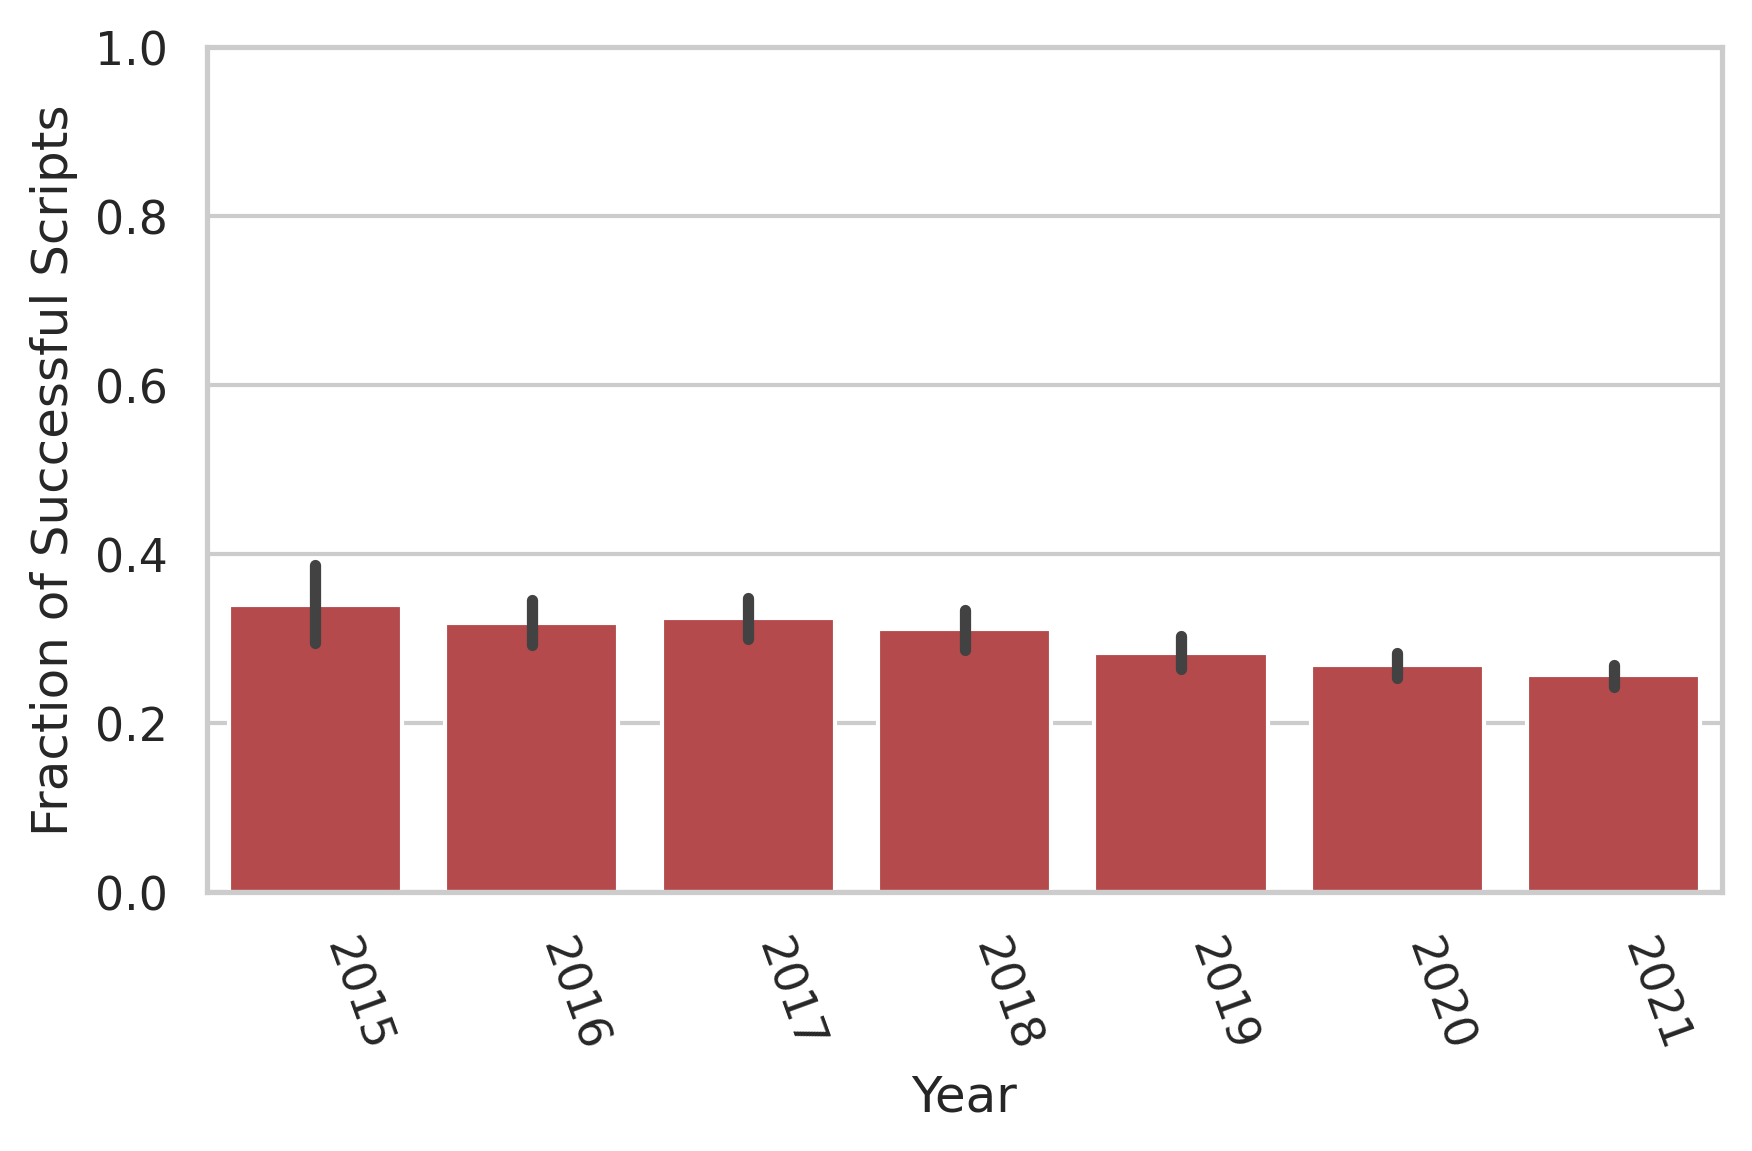

In [35]:
plt.figure(dpi=300)
plt.xticks(rotation=-70, ha = "left")
plt.ylim(0,1)
sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("notebook")
ax = sns.barplot(x=plot_years_df['Year'], 
                 y=plot_years_df['Raas_Is_Successful'],
                 order=["2015", "2016", "2017", "2018", "2019", "2020", "2021"],
                 palette=sns.color_palette("Set1", n_colors=1, desat=.7))
#ax.set_title('Script Failure Proportion by Subject')
ax.set_xlabel("Year")
ax.set_ylabel("Fraction of Successful Scripts")
plt.tight_layout()
plt.show()